# 💻 GRAD-CAM - IA explicável
## Visualização de Regiões Importantes para Classificação

Este notebook implementa **Grad-CAM** (Gradient-weighted Class Activation Mapping) para visualizar **onde** o modelo ResNet50 está olhando ao fazer predições de pneumonia.

# Se der problema, rode a linha de código abaixo, para instalar o opencv, caso contrário ignore o comando abaixo.

In [7]:
!pip install opencv-python

  Using cached opencv_python-4.13.0.92-cp37-abi3-win_amd64.whl.metadata (20 kB)
  Using cached numpy-2.2.6-cp310-cp310-win_amd64.whl.metadata (60 kB)
Using cached opencv_python-4.13.0.92-cp37-abi3-win_amd64.whl (40.2 MB)
Using cached numpy-2.2.6-cp310-cp310-win_amd64.whl (12.9 MB)

  Attempting uninstall: numpy

    Found existing installation: numpy 1.26.4

   ---------------------------------------- 0/2 [numpy]
    Uninstalling numpy-1.26.4:
   ---------------------------------------- 0/2 [numpy]
   ---------------------------------------- 0/2 [numpy]
   ---------------------------------------- 0/2 [numpy]
   ---------------------------------------- 0/2 [numpy]
   ---------------------------------------- 0/2 [numpy]
   ---------------------------------------- 0/2 [numpy]
   ---------------------------------------- 0/2 [numpy]
   ---------------------------------------- 0/2 [numpy]
      Successfully uninstalled numpy-1.26.4
   ---------------------------------------- 0/2 [numpy]
   -

  You can safely remove it manually.
  You can safely remove it manually.
ERROR: Could not install packages due to an OSError: [WinError 5] Acesso negado: 'C:\\Users\\Desenvolvedor\\Documents\\Visão computacional\\venv\\Lib\\site-packages\\cv2\\cv2.pyd'
Check the permissions.



## 📚 Imports

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import os
from torchvision import transforms
from torchvision.models import resnet50, ResNet50_Weights

print("✅ Imports carregados com sucesso!")

✅ Imports carregados com sucesso!


## 🧠 Classe Grad-CAM

In [9]:
class GradCAM:
    
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        
        # Registrar hooks para capturar ativações e gradientes
        self.target_layer.register_forward_hook(self.save_activation)
        self.target_layer.register_full_backward_hook(self.save_gradient)
    
    def save_activation(self, module, input, output):
        """Salva ativações da camada durante forward pass"""
        self.activations = output.detach()
    
    def save_gradient(self, module, grad_input, grad_output):
        """Salva gradientes durante backward pass"""
        self.gradients = grad_output[0].detach()
    
    def generate_cam(self, input_image, target_class=None):

        # Forward pass
        self.model.eval()
        output = self.model(input_image)
        
        # Calcular probabilidades e predição
        probabilities = F.softmax(output, dim=1)
        prediction = output.argmax(dim=1).item()
        confidence = probabilities[0, prediction].item()
        
        # Usar predição como target se não especificado
        if target_class is None:
            target_class = prediction
        
        # Backward pass
        self.model.zero_grad()
        one_hot = torch.zeros_like(output)
        one_hot[0, target_class] = 1
        output.backward(gradient=one_hot, retain_graph=True)
        
        # Calcular pesos (Global Average Pooling dos gradientes)
        weights = torch.mean(self.gradients, dim=(2, 3), keepdim=True)
        
        # Combinação ponderada das ativações
        cam = torch.sum(weights * self.activations, dim=1, keepdim=True)
        
        # ReLU (manter apenas valores positivos)
        cam = F.relu(cam)
        
        # Normalizar para [0, 1]
        cam = cam.squeeze().cpu().numpy()
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
        
        return cam, prediction, confidence

print("✅ Classe GradCAM criada!")
print("   Permite visualizar onde o modelo está 'olhando'")

✅ Classe GradCAM criada!
   Permite visualizar onde o modelo está 'olhando'


## 🎨 Funções de Visualização

In [10]:
def apply_colormap_on_image(image, cam, alpha=0.5):
    
    
    # Redimensionar CAM para o tamanho da imagem
    cam_resized = cv2.resize(cam, (image.shape[1], image.shape[0]))
    
    # Aplicar colormap JET (azul→verde→amarelo→vermelho)
    heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    
    # Converter imagem para [0, 255] se necessário
    if image.max() <= 1.0:
        image = (image * 255).astype(np.uint8)
    
    # Sobrepor heatmap na imagem
    superimposed = heatmap * alpha + image * (1 - alpha)
    superimposed = np.clip(superimposed, 0, 255).astype(np.uint8)
    
    return superimposed


def denormalize_image(tensor, mean, std):
    
    img = tensor.clone()
    
    # Desnormalizar cada canal
    for t, m, s in zip(img, mean, std):
        t.mul_(s).add_(m)
    
    # Garantir valores em [0, 1]
    img = torch.clamp(img, 0, 1)
    
    # Converter para numpy [H, W, C]
    img = img.permute(1, 2, 0).cpu().numpy()
    
    return img

print("✅ Funções de visualização criadas!")

✅ Funções de visualização criadas!


## 📂 Carregar Modelo Treinado

In [ ]:
# Configurações
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🖥️ Device: {device}")

# Caminho do modelo
MODEL_PATH = 'modelo_colab_resnet50.pth' 

print(f"\n📂 Carregando modelo: {MODEL_PATH}")

# arquitetura igual a do treinamento
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)

num_features = model.fc.in_features

model.fc = nn.Sequential(
  nn.Linear(num_features, 512),
  nn.BatchNorm1d(512),
  nn.ReLU(),
  nn.Dropout(0.3),
  nn.Linear(512, 2)
)

# Carregar pesos treinados
checkpoint = torch.load(
    MODEL_PATH,
    map_location=device,
    weights_only=False  # Isso daqui tem q colocar, pq no pytorch 2.6+ mudou
)

model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)
model.eval()

print("✅ Modelo carregado com sucesso!")

# Mostrar métricas do modelo
if 'val_acc' in checkpoint:
    print(f"   📊 Val Accuracy: {checkpoint['val_acc']:.2f}%")
if 'val_roc_auc' in checkpoint:
    print(f"   📈 Val ROC-AUC: {checkpoint['val_roc_auc']:.4f}")

🖥️ Device: cpu

📂 Carregando modelo: modelo_colab_resnet50.pth
✅ Modelo carregado com sucesso!
   📊 Val Accuracy: 98.28%
   📈 Val ROC-AUC: 0.9980


## 🎯 Função Principal de Visualização

In [ ]:
def visualize_gradcam(image_path, save_path=None):

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    # Carregar imagem
    image_original = Image.open(image_path).convert('RGB')
    image_tensor = transform(image_original).unsqueeze(0).to(device)
    
    # Criar Grad-CAM (usar layer4 = última camada convolucional do ResNet que tá igual not reinamento)
    grad_cam = GradCAM(model, model.layer4)
    
    # Gerar mapa de calor
    cam, prediction, confidence = grad_cam.generate_cam(image_tensor)
    
    # Desnormalizar imagem para visualização
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    image_denorm = denormalize_image(image_tensor.squeeze(), mean, std)
    
    # Aplicar o mapa de calor sobre a imagem
    image_with_cam = apply_colormap_on_image(image_denorm, cam, alpha=0.5)
    
    # Classes
    class_names = ['NORMAL', 'PNEUMONIA']
    
    # Criar visualização
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # 1. Imagem Original
    axes[0].imshow(image_original)
    axes[0].set_title('🔵 Imagem Original', fontsize=14, fontweight='bold')
    axes[0].axis('off')
    
    # 2. Mapa de Calor Puro
    im = axes[1].imshow(cam, cmap='jet')
    axes[1].set_title('🔥 Grad-CAM Heatmap', fontsize=14, fontweight='bold')
    axes[1].axis('off')
    plt.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04)
    
    # 3. Sobreposição
    axes[2].imshow(image_with_cam)
    color = 'green' if prediction == 1 else 'blue'
    axes[2].set_title(
        f'🎯 Predição: {class_names[prediction]}\n'
        f'Confiança: {confidence:.1%}',
        fontsize=14,
        fontweight='bold',
        color=color
    )
    axes[2].axis('off')
    
    # Adicionar explicação
    fig.text(
        0.5, 0.02,
        '🔴 Vermelho = Região IMPORTANTE | 🟡 Amarelo = Moderada | 🔵 Azul = Ignorada',
        ha='center',
        fontsize=12,
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3)
    )
    
    plt.tight_layout(rect=[0, 0.03, 1, 1])
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✅ Salvo em: {save_path}")
    
    plt.show()
    
    # Imprimir resultado
    print(f"\n📊 Resultado:")
    print(f"   Predição: {class_names[prediction]}")
    print(f"   Confiança: {confidence:.1%}")
    print(f"   Arquivo: {os.path.basename(image_path)}")
    
    return cam, prediction, confidence

print("✅ Função de visualização criada!")
print("   Use: visualize_gradcam('caminho/da/imagem.jpeg')")

✅ Função de visualização criada!
   Use: visualize_gradcam('caminho/da/imagem.jpeg')


## 🖼️ Visualização de uma Imagem

🖼️ Processando: dataset/train/PNEUMONIA/BACTERIA-60241-0001.jpeg



C:\Users\Desenvolvedor\AppData\Local\Temp\ipykernel_2828\4117525418.py:65: UserWarning: Glyph 128309 (\N{LARGE BLUE CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 1])
C:\Users\Desenvolvedor\AppData\Local\Temp\ipykernel_2828\4117525418.py:65: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 1])
C:\Users\Desenvolvedor\AppData\Local\Temp\ipykernel_2828\4117525418.py:65: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 1])
C:\Users\Desenvolvedor\AppData\Local\Temp\ipykernel_2828\4117525418.py:68: UserWarning: Glyph 128309 (\N{LARGE BLUE CIRCLE}) missing from font(s) DejaVu Sans.
  plt.savefig(save_path, dpi=300, bbox_inches='tight')
C:\Users\Desenvolvedor\AppData\Local\Temp\ipykernel_2828\4117525418.py:68: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  plt.savefig(save_path, dpi=300, bbox_inches='tight')
C:\Us

✅ Salvo em: gradcam_results/gradcam_example.png


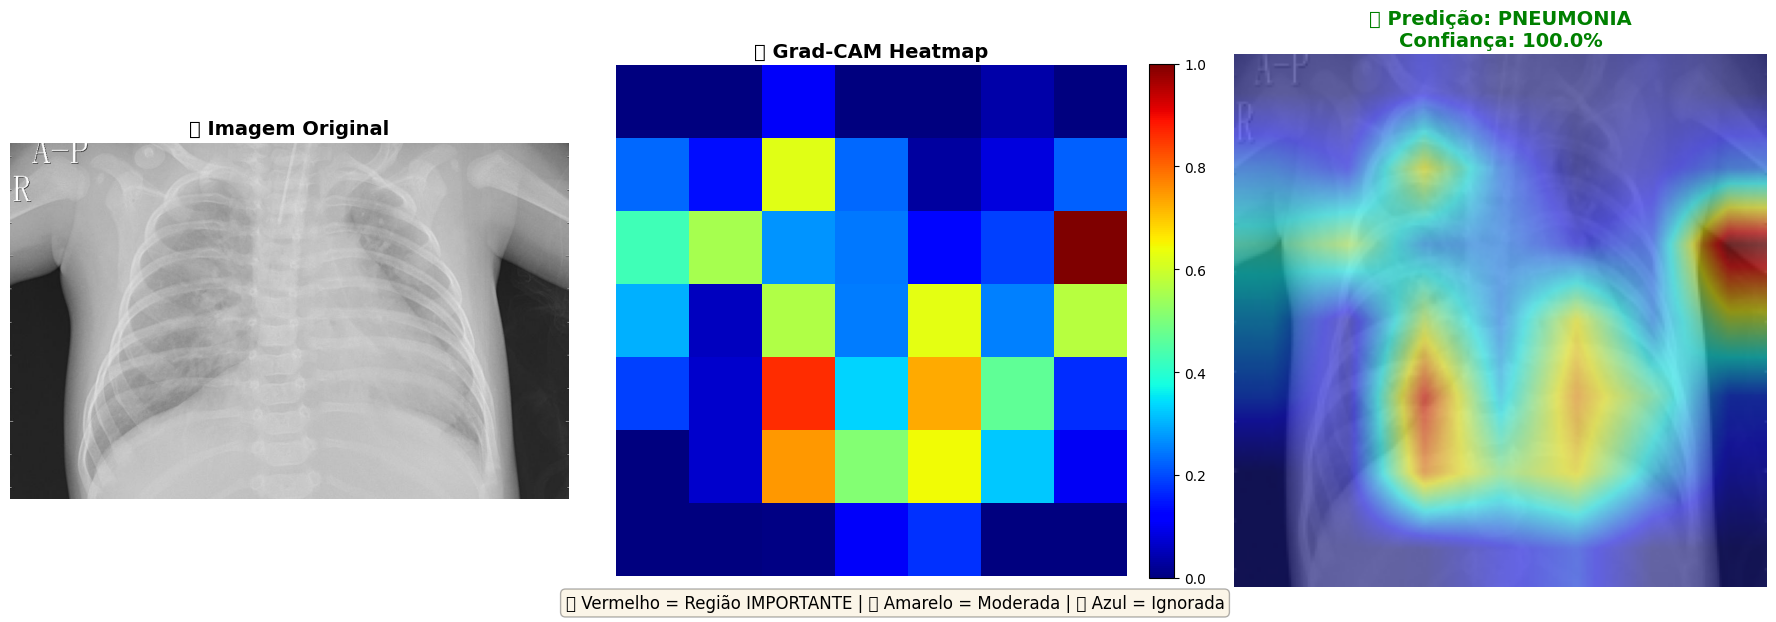


📊 Resultado:
   Predição: PNEUMONIA
   Confiança: 100.0%
   Arquivo: BACTERIA-60241-0001.jpeg


In [14]:

image_path = 'dataset/train/PNEUMONIA/BACTERIA-60241-0001.jpeg' 

print(f"🖼️ Processando: {image_path}\n")

# Gerar visualização
cam, pred, conf = visualize_gradcam(
    image_path,
    save_path='gradcam_results/gradcam_example.png'  
)

## 📊 Visualização de vvárias Imagens


📂 Classe: NORMAL
Encontradas 2 imagens


🖼️ Imagem 1/2


C:\Users\Desenvolvedor\AppData\Local\Temp\ipykernel_15576\4117525418.py:65: UserWarning: Glyph 128309 (\N{LARGE BLUE CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 1])
C:\Users\Desenvolvedor\AppData\Local\Temp\ipykernel_15576\4117525418.py:65: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 1])
C:\Users\Desenvolvedor\AppData\Local\Temp\ipykernel_15576\4117525418.py:65: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 1])
C:\Users\Desenvolvedor\AppData\Local\Temp\ipykernel_15576\4117525418.py:68: UserWarning: Glyph 128309 (\N{LARGE BLUE CIRCLE}) missing from font(s) DejaVu Sans.
  plt.savefig(save_path, dpi=300, bbox_inches='tight')
C:\Users\Desenvolvedor\AppData\Local\Temp\ipykernel_15576\4117525418.py:68: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  plt.savefig(save_path, dpi=300, bbox_inches='tight')


✅ Salvo em: gradcam_results/NORMAL_1.png


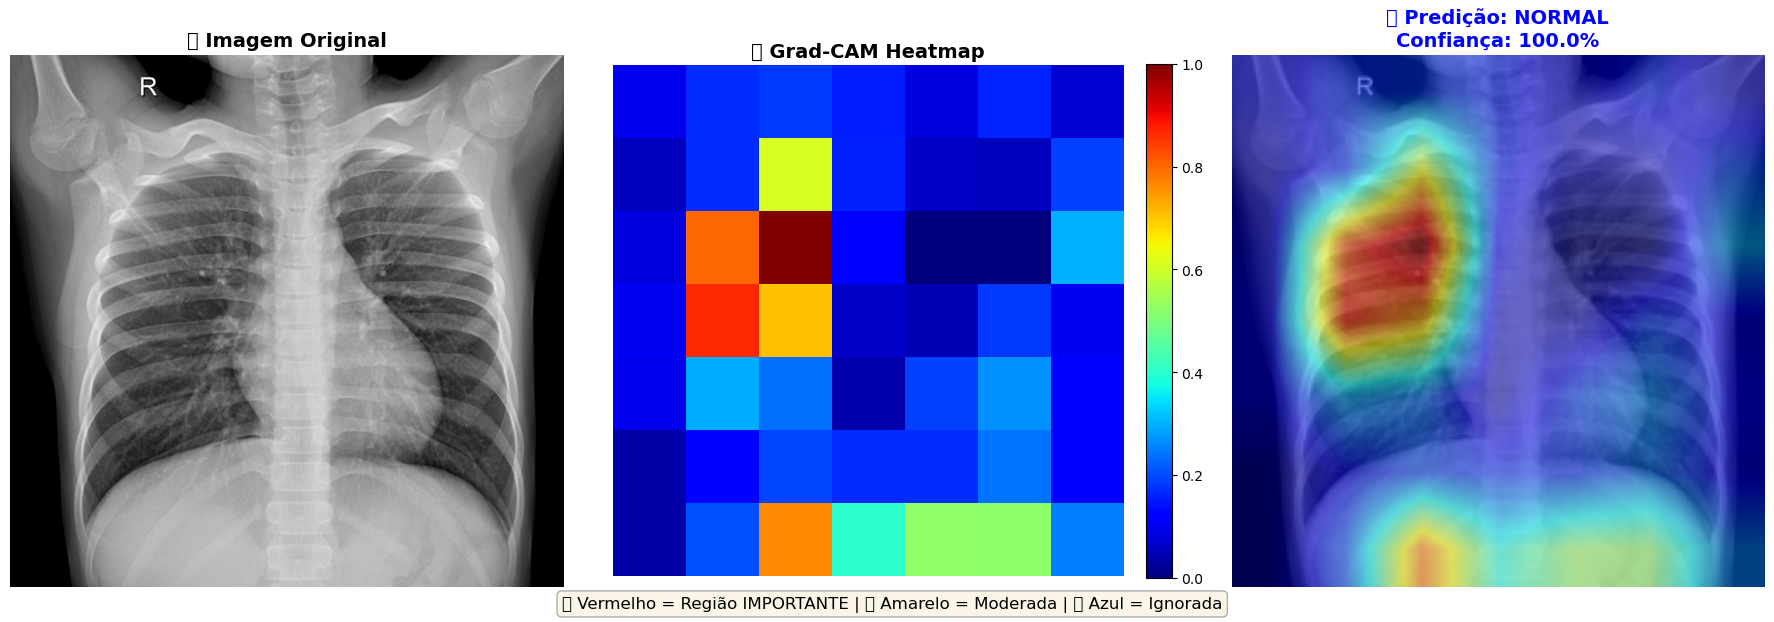


📊 Resultado:
   Predição: NORMAL
   Confiança: 100.0%
   Arquivo: NORMAL-1003233-0001.jpeg
   ✅ Predição CORRETA

🖼️ Imagem 2/2
✅ Salvo em: gradcam_results/NORMAL_2.png


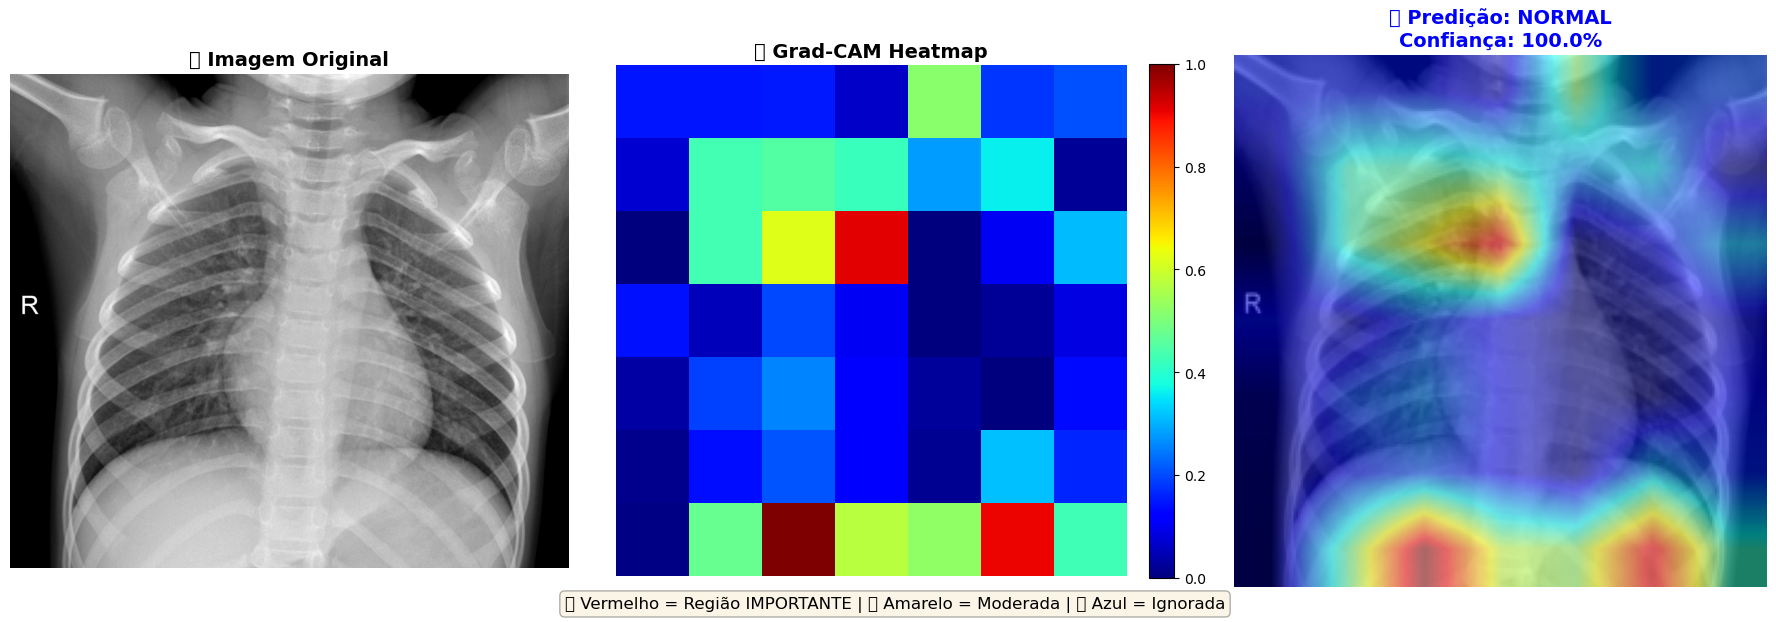


📊 Resultado:
   Predição: NORMAL
   Confiança: 100.0%
   Arquivo: NORMAL-1012843-0001.jpeg
   ✅ Predição CORRETA

📂 Classe: PNEUMONIA
Encontradas 2 imagens


🖼️ Imagem 1/2
✅ Salvo em: gradcam_results/PNEUMONIA_1.png


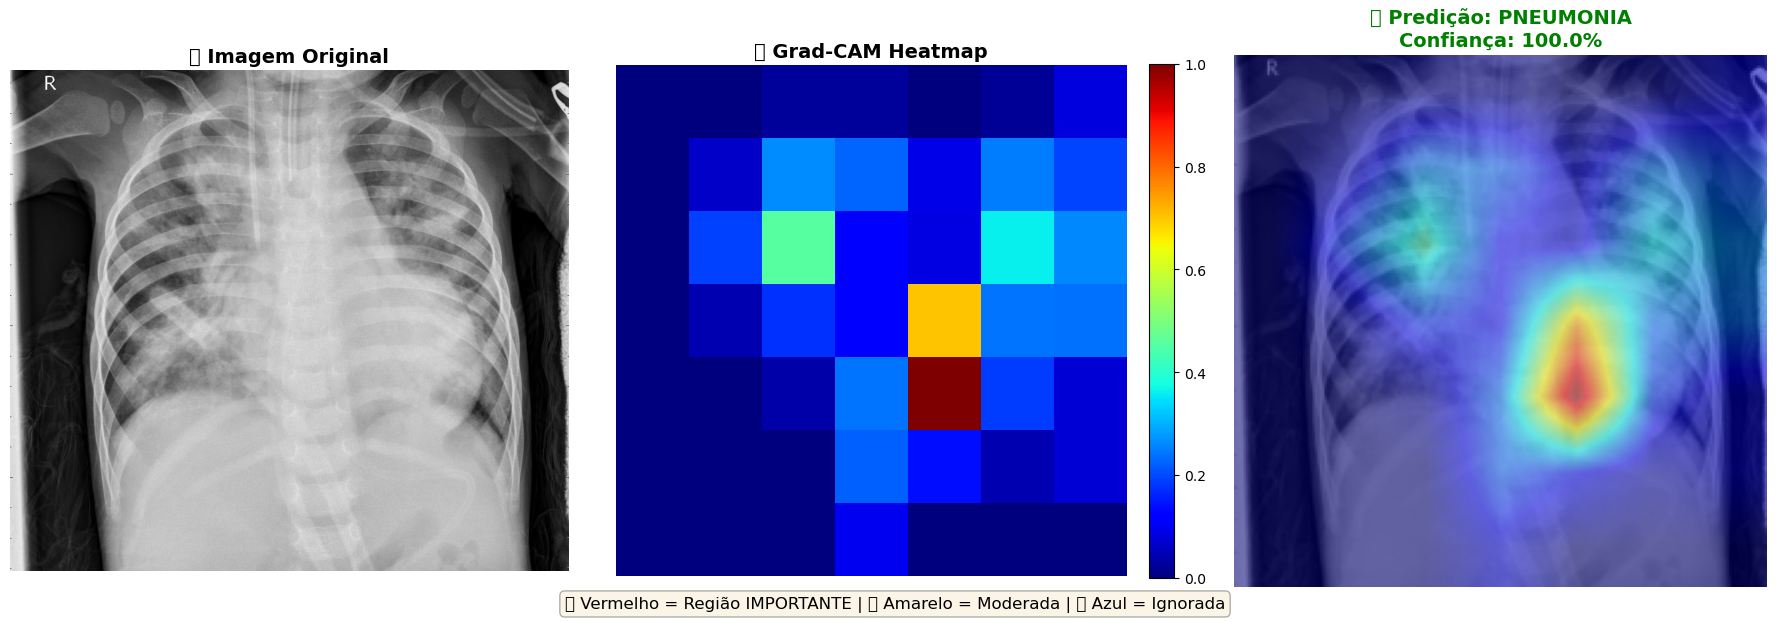


📊 Resultado:
   Predição: PNEUMONIA
   Confiança: 100.0%
   Arquivo: BACTERIA-1008087-0001.jpeg
   ✅ Predição CORRETA

🖼️ Imagem 2/2
✅ Salvo em: gradcam_results/PNEUMONIA_2.png


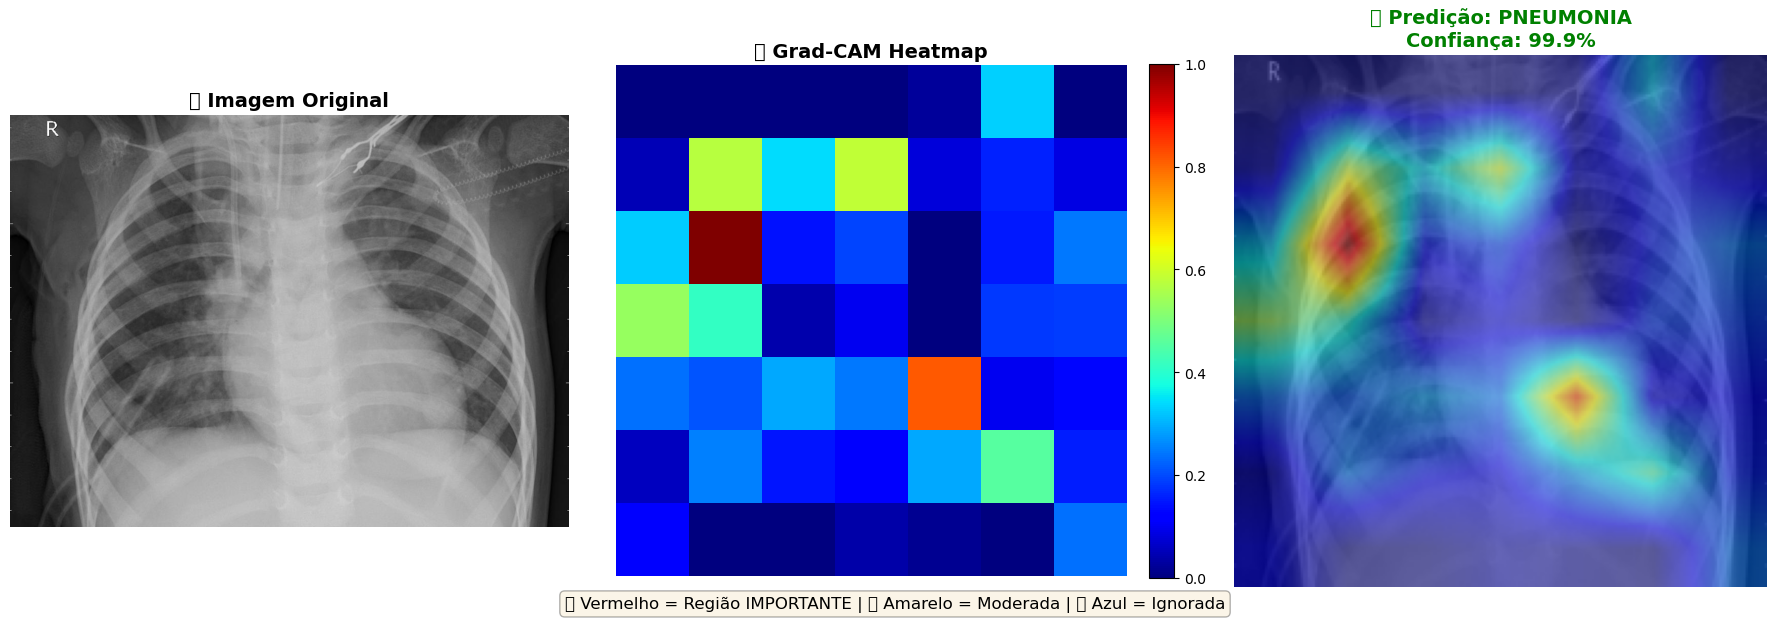


📊 Resultado:
   Predição: PNEUMONIA
   Confiança: 99.9%
   Arquivo: BACTERIA-1025587-0001.jpeg
   ✅ Predição CORRETA

🎉 CONCLUÍDO!
📁 Resultados salvos em: gradcam_results/


In [ ]:
def visualize_multiple_samples(data_dir, num_samples=2):
    
    class_names = ['NORMAL', 'PNEUMONIA']
    
    # Criar uma pasta para salvar os resultados
    os.makedirs('gradcam_results', exist_ok=True)
    
    for class_name in class_names:
        print("\n" + "="*46)
        print(f"📂 Classe: {class_name}")
        print("="*46)
        
        # Caminho da classe
        class_dir = os.path.join(data_dir, class_name)
        
        if not os.path.exists(class_dir):
            print(f"❌ Diretório não encontrado: {class_dir}")
            continue
        
        # Listar as imagens
        images = [
            os.path.join(class_dir, f)
            for f in os.listdir(class_dir)
            if f.lower().endswith(('.jpg', '.jpeg', '.png'))
        ][:num_samples]
        
        print(f"Encontradas {len(images)} imagens\n")
        
        # Processa cada imagem
        for i, img_path in enumerate(images, 1):
            print(f"\n🖼️ Imagem {i}/{num_samples}")
            
            save_path = f'gradcam_results/{class_name}_{i}.png'
            
            try:
                cam, pred, conf = visualize_gradcam(img_path, save_path)
                
                # Verificar se a predição está correta
                true_label = class_names.index(class_name)
                if pred == true_label:
                    print("   ✅ Predição CORRETA")
                else:
                    print("   ❌ Predição INCORRETA")
            
            except Exception as e:
                print(f"   ❌ Erro: {e}")
    
    print("\n" + "="*50)
    print("🎉 CONCLUÍDO!")
    print("="*50)
    print("📁 Resultados salvos em: gradcam_results/")

# Executar
DATA_DIR = 'dataset/train'  

visualize_multiple_samples(DATA_DIR, num_samples=2)

## 🎨 EGrid de Comparação (NORMAL vs PNEUMONIA) para relatório

C:\Users\Desenvolvedor\AppData\Local\Temp\ipykernel_15576\1610325498.py:77: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Desenvolvedor\AppData\Local\Temp\ipykernel_15576\1610325498.py:81: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  plt.savefig('gradcam_results/comparison_grid.png', dpi=300, bbox_inches='tight')


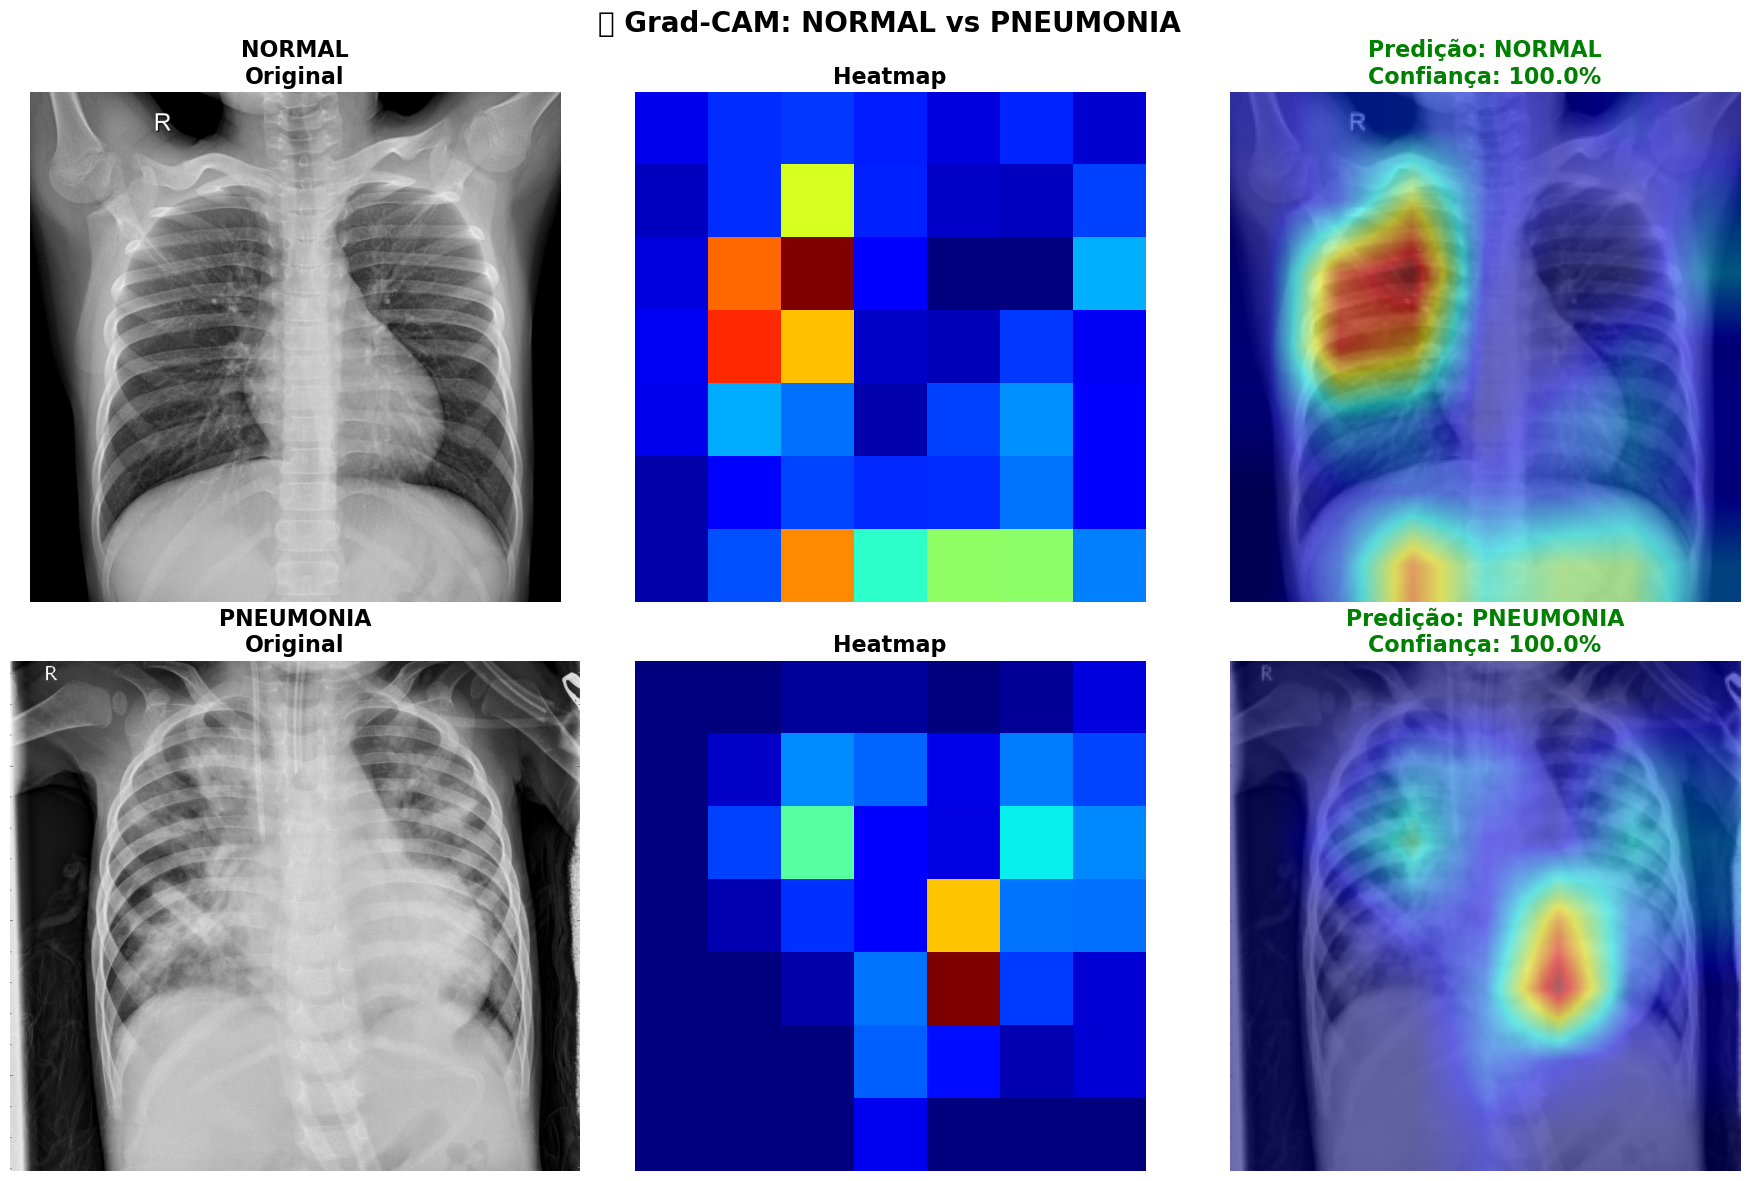

✅ Grid de comparação salvo: gradcam_results/comparison_grid.png


In [11]:
def create_comparison_grid(data_dir):
    """
    Cria um grid comparativo: NORMAL vs PNEUMONIA lado a lado.
    """
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    class_names = ['NORMAL', 'PNEUMONIA']
    
    # Coletar 1 imagem de cada classe
    sample_images = {}
    for class_name in class_names:
        class_dir = os.path.join(data_dir, class_name)
        images = [
            os.path.join(class_dir, f)
            for f in os.listdir(class_dir)
            if f.lower().endswith(('.jpg', '.jpeg', '.png'))
        ]
        sample_images[class_name] = images[0] if images else None
    
    # Criar grid 2x3
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    for row, class_name in enumerate(class_names):
        if sample_images[class_name] is None:
            continue
        
        image_path = sample_images[class_name]
        
        # Carregar imagem
        image_original = Image.open(image_path).convert('RGB')
        image_tensor = transform(image_original).unsqueeze(0).to(device)
        
        # Grad-CAM
        grad_cam = GradCAM(model, model.layer4)
        cam, pred, conf = grad_cam.generate_cam(image_tensor)
        
        # Desnormalizar
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
        image_denorm = denormalize_image(image_tensor.squeeze(), mean, std)
        image_with_cam = apply_colormap_on_image(image_denorm, cam, alpha=0.5)
        
        # Plot
        axes[row, 0].imshow(image_original)
        axes[row, 0].set_title(
            f'{class_name}\nOriginal',
            fontsize=16,
            fontweight='bold'
        )
        axes[row, 0].axis('off')
        
        axes[row, 1].imshow(cam, cmap='jet')
        axes[row, 1].set_title('Heatmap', fontsize=16, fontweight='bold')
        axes[row, 1].axis('off')
        
        color = 'green' if pred == row else 'red'
        axes[row, 2].imshow(image_with_cam)
        axes[row, 2].set_title(
            f'Predição: {class_names[pred]}\nConfiança: {conf:.1%}',
            fontsize=16,
            fontweight='bold',
            color=color
        )
        axes[row, 2].axis('off')
    
    plt.suptitle(
        '🔥 Grad-CAM: NORMAL vs PNEUMONIA',
        fontsize=20,
        fontweight='bold',
        y=0.98
    )
    
    plt.tight_layout()
    
    # Salvar
    os.makedirs('gradcam_results', exist_ok=True)
    plt.savefig('gradcam_results/comparison_grid.png', dpi=300, bbox_inches='tight')
    
    plt.show()
    
    print("✅ Grid de comparação salvo: gradcam_results/comparison_grid.png")

# Executar
create_comparison_grid('dataset/train')

## 📊 INTERPRETAÇÃO DOS RESULTADOS

### 🎨 **Cores do Heatmap:**
- 🔴 **Vermelho:** Região **MUITO** importante para a decisão
- 🟡 **Amarelo:** Região **moderadamente** importante
- 🟢 **Verde:** Região **pouco** importante
- 🔵 **Azul:** Região **ignorada** pelo modelo

